 1. Найти или сгенерировать набор данных для бинарной классификации графов.
 2. Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
  - K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными
 3. Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
 4. (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

# Part 1. Датасет

In [17]:
import numpy as np
import networkx as nx
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from ogb.graphproppred import GraphPropPredDataset
from sklearn.model_selection import train_test_split
from collections import defaultdict


In [18]:
dataset = GraphPropPredDataset(name='ogbg-molhiv')
labels = dataset.labels.flatten()

/Users/forcemajor01/miniconda3/envs/study/lib/python3.9/site-packages/ogb/graphproppred/dataset.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load

In [19]:
dataset[0]

({'edge_index': array([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
           6,  9,  4, 10, 10, 11, 11, 12, 12, 13, 11, 14, 14, 15, 15, 16,
          16, 17, 15, 18,  9,  2, 18,  4],
         [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,
           9,  6, 10,  4, 11, 10, 12, 11, 13, 12, 14, 11, 15, 14, 16, 15,
          17, 16, 18, 15,  2,  9,  4, 18]]),
  'edge_feat': array([[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         

In [20]:
count_0 = np.count_nonzero(labels == 0)
count_1 = np.count_nonzero(labels == 1)

print(f"Количество 0: {count_0}")
print(f"Количество 1: {count_1}")

Количество 0: 39684
Количество 1: 1443


In [26]:
# Функция для преобразования edge_index в объект networkx графа
def edge_index_to_graph(edge_index):
    edges = list(zip(edge_index[0], edge_index[1]))
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

graphs = [edge_index_to_graph(data['edge_index']) for data, _ in dataset]

**Метка 0***

Фичи первых 5 нод:
 [[ 5  0  4  5  3  0  2  0  0]
 [ 5  0  4  5  2  0  2  0  0]
 [ 5  0  3  5  0  0  1  0  1]
 [ 7  0  2  6  0  0  1  0  1]
 [28  0  4  2  0  0  5  0  1]]
Фичи первых 5 ребер:
 [[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [1 0 0]]
Метка графа с индексом 0: 0


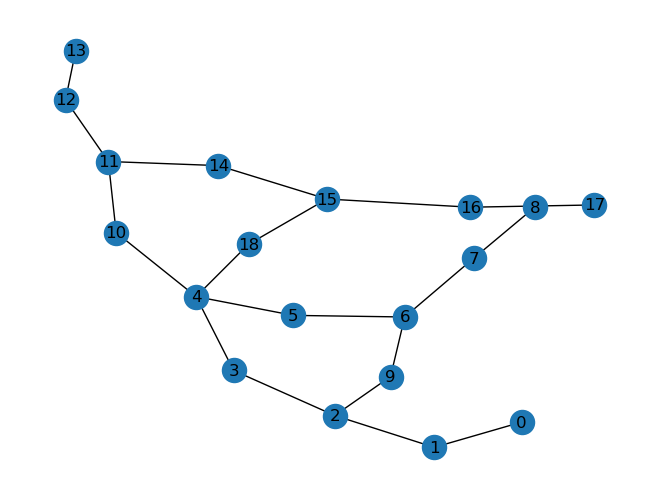

In [27]:
# Посмотрим
negative_graph_index = np.where(labels == 0)[0][0]  # Первый граф с меткой 0

# Получим данные этого графа
negative_graph_data = dataset[negative_graph_index][0]

# Фичи узлов
node_features = negative_graph_data['node_feat']
print("Фичи первых 5 нод:\n", node_features[:5])

# Фичи рёбер
edge_features = negative_graph_data['edge_feat']
print("Фичи первых 5 ребер:\n", edge_features[:5])

edges = list(zip(negative_graph_data['edge_index'][0], negative_graph_data['edge_index'][1]))
G = nx.Graph()
G.add_edges_from(edges)

nx.draw(G, with_labels=True)

# Выводим метку графа
graph_label = labels[negative_graph_index]
print(f"Метка графа с индексом {negative_graph_index}: {graph_label}")

**Метка 1***

Фичи первых 5 нод:
 [[7 0 1 5 0 0 1 0 0]
 [5 0 3 5 0 0 1 0 0]
 [7 0 2 5 1 0 1 0 0]
 [5 0 4 5 2 0 2 0 0]
 [5 0 3 5 0 0 1 1 1]]
Фичи первых 5 ребер:
 [[1 0 1]
 [1 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 0]]
Метка графа с индексом 11: 1


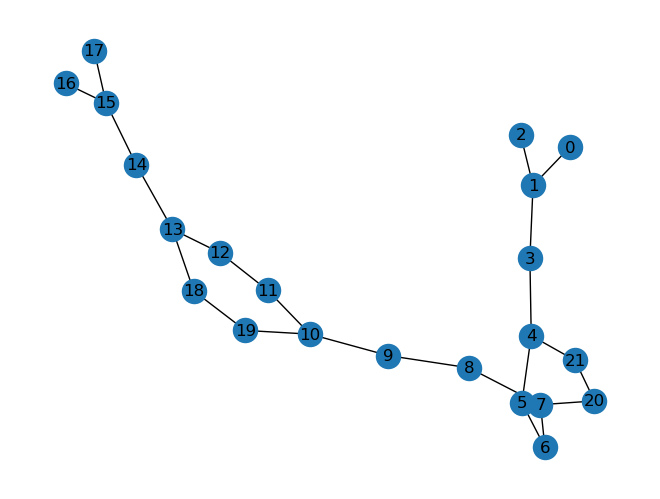

In [28]:
# Найдем индекс первого графа с меткой 1
positive_graph_index = np.where(labels == 1)[0][0]  # Первый граф с меткой 1

# Получим данные этого графа
positive_graph_data = dataset[positive_graph_index][0]

node_features = positive_graph_data['node_feat']
print("Фичи первых 5 нод:\n", node_features[:5])

edge_features = positive_graph_data['edge_feat']
print("Фичи первых 5 ребер:\n", edge_features[:5])

# Преобразуем edge_index в граф networkx
edges = list(zip(positive_graph_data['edge_index'][0], positive_graph_data['edge_index'][1]))
G = nx.Graph()
G.add_edges_from(edges)

nx.draw(G, with_labels=True)

# Выводим метку графа
graph_label = labels[positive_graph_index]
print(f"Метка графа с индексом {positive_graph_index}: {graph_label}")

# Part 2. shortest_path_kernel

Опишите графы с помощью вектора из количества кратчайших путей различной длины

Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)

In [29]:
# Функция для вычисления вектора количества кратчайших путей для графа
def graph_to_shortest_path_vector(graph):
    """Преобразование графа в вектор, представляющий количество кратчайших путей различной длины"""
    path_lengths = dict(nx.shortest_path_length(graph))

    # Находим максимальную длину кратчайшего пути
    max_length = max(max(lengths.values()) for lengths in path_lengths.values() if lengths)

    # Создаем вектор, где каждый индекс соответствует длине пути, а значение - количеству путей такой длины
    path_vector = np.zeros(max_length + 1)  # +1, чтобы учесть длину 0

    for lengths in path_lengths.values():
        for length in lengths.values():
            path_vector[length] += 1

    return path_vector

Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
- K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
- K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными

In [30]:
# Функция для вычисления матриц ядер K_train и K_test
def shortest_path_kernel(train_graphs, test_graphs):
    """Вычисление ядровых матриц для тренировочных и тестовых графов"""
    # Преобразуем каждый граф в вектор кратчайших путей
    train_vectors = [graph_to_shortest_path_vector(g) for g in train_graphs]
    test_vectors = [graph_to_shortest_path_vector(g) for g in test_graphs]

    # Приводим все векторы к одинаковой длине (по максимальной длине среди всех векторов)
    max_len = max(max(len(v) for v in train_vectors), max(len(v) for v in test_vectors))
    train_vectors = [np.pad(v, (0, max_len - len(v))) for v in train_vectors]
    test_vectors = [np.pad(v, (0, max_len - len(v))) for v in test_vectors]

    # Вычисляем K_train и K_test через скалярное произведение векторов
    K_train = np.dot(train_vectors, np.transpose(train_vectors))
    K_test = np.dot(test_vectors, np.transpose(train_vectors))

    return K_train, K_test

In [31]:

# Выбираем графы класса 0 и класса 1
class_0_indices = np.where(labels == 0)[0]
class_1_indices = np.where(labels == 1)[0]

# Отбираем по 1400 объектов каждого класса
selected_class_0 = class_0_indices[:1400]
selected_class_1 = class_1_indices[:1400]

# Отбираем графы и метки по выбранным индексам
selected_indices = np.concatenate([selected_class_0, selected_class_1])
selected_graphs = [graphs[i] for i in selected_indices]
selected_labels = labels[selected_indices]


# Разделим данные на тренировочные и тестовы
# Разделим данные на тренировочные и тестовые
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    selected_graphs, selected_labels, test_size=0.2, random_state=42
)

# Вычислим матрицы ядер
K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)

# Проверим размеры матриц
print("Размер K_train:", K_train.shape)
print("Размер K_test:", K_test.shape)


Размер K_train: (2240, 2240)
Размер K_test: (560, 2240)


In [16]:
param_grid = {'C': [0.1, 1, 10]}  # Сетка гиперпараметров для подбора
svc = SVC(kernel='precomputed')

# Подбор гиперпараметров с помощью кросс-валидации
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(K_train, train_labels)

# Лучшая модель
best_model = grid_search.best_estimator_

train_pred = best_model.predict(K_train)
test_pred = best_model.predict(K_test)

train_accuracy = accuracy_score(train_labels, train_pred)
test_accuracy = accuracy_score(test_labels, test_pred)
test_f1 = f1_score(test_labels, test_pred)


print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Полный отчет о классификации
print("\nClassification Report on Test Set:\n")
print(classification_report(test_labels, test_pred))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   0.8s
[CV] END ..............................................C=0.1; total time=   1.9s
[CV] END ................................................C=1; total time=  17.3s
[CV] END ................................................C=1; total time=  10.0s
[CV] END ................................................C=1; total time=  14.7s
[CV] END ...............................................C=10; total time= 2.7min
[CV] END ...............................................C=10; total time= 1.7min
[CV] END ...............................................C=10; total time= 2.6min
Train Accuracy: 0.6875
Test Accuracy: 0.6964
Test F1 Score: 0.6731

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       291

# (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [33]:
def weisfeiler_lehman_step(graph, labels):
    new_labels = {}
    for node in graph.nodes():
        # Получаем метки соседей
        neighbors_labels = [labels[neighbor] for neighbor in graph.neighbors(node)]
        # Сортируем метки соседей для инвариантности
        neighbors_labels = sorted(neighbors_labels)
        # Обновляем метку узла
        new_labels[node] = hash((labels[node], tuple(neighbors_labels)))
    return new_labels

def weisfeiler_lehman_kernel(train_graphs, test_graphs, h=2):

    # Начальные метки (все узлы получают одинаковую метку)
    train_labels = [{node: 1 for node in graph.nodes()} for graph in train_graphs]
    test_labels = [{node: 1 for node in graph.nodes()} for graph in test_graphs]

    # Словари для хранения частот меток на каждой итерации
    train_label_freq = [defaultdict(int) for _ in range(len(train_graphs))]
    test_label_freq = [defaultdict(int) for _ in range(len(test_graphs))]

    for _ in range(h):
        # Для каждого графа обновляем метки и считаем частоты
        for i, graph in enumerate(train_graphs):
            train_labels[i] = weisfeiler_lehman_step(graph, train_labels[i])
            for label in train_labels[i].values():
                train_label_freq[i][label] += 1
        
        for i, graph in enumerate(test_graphs):
            test_labels[i] = weisfeiler_lehman_step(graph, test_labels[i])
            for label in test_labels[i].values():
                test_label_freq[i][label] += 1

    # Вычисляем K_train и K_test через скалярное произведение частот меток
    K_train = np.zeros((len(train_graphs), len(train_graphs)))
    K_test = np.zeros((len(test_graphs), len(train_graphs)))

    for i in range(len(train_graphs)):
        for j in range(i, len(train_graphs)):
            common_labels = set(train_label_freq[i].keys()).intersection(train_label_freq[j].keys())
            K_train[i, j] = K_train[j, i] = sum(min(train_label_freq[i][label], train_label_freq[j][label]) for label in common_labels)

    for i in range(len(test_graphs)):
        for j in range(len(train_graphs)):
            common_labels = set(test_label_freq[i].keys()).intersection(train_label_freq[j].keys())
            K_test[i, j] = sum(min(test_label_freq[i][label], train_label_freq[j][label]) for label in common_labels)

    return K_train, K_test


In [35]:
# Вычислим матрицы ядер для Weisfeiler-Lehman Kernel
K_train_wl, K_test_wl = weisfeiler_lehman_kernel(train_graphs, test_graphs)

# Проверим размеры матриц
print("Размер K_train для WL Kernel:", K_train_wl.shape)
print("Размер K_test для WL Kernel:", K_test_wl.shape)

Размер K_train для WL Kernel: (2240, 2240)
Размер K_test для WL Kernel: (560, 2240)


In [43]:
# Обучение модели SVC с WL Kernel
param_grid = {'C': [0.01, 0.1, 1, 10]}
svc_wl = SVC(kernel='precomputed')

# Подбор гиперпараметров
grid_search_wl = GridSearchCV(svc_wl, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_wl.fit(K_train_wl, train_labels)

# Лучшая модель
best_model_wl = grid_search_wl.best_estimator_
test_pred_wl = best_model_wl.predict(K_test_wl)
test_accuracy_wl = accuracy_score(test_labels, test_pred_wl)
test_f1_wl = f1_score(test_labels, test_pred_wl)

print(f"Test Accuracy (WL Kernel): {test_accuracy_wl:.4f}")
print(f"Test F1 Score (WL Kernel): {test_f1_wl:.4f}")

print("\nClassification Report on Test Set (WL Kernel):\n")
print(classification_report(test_labels, test_pred_wl))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ...............................................C=10; total time=   1.0s
[CV] END ...............................................C=10; total time=   0.9s
[CV] END ........................................

# Вывод

Скор Увеличился на 0.1 по F1 с 0.6731 до 0.7706 при использовании  Weisfeiler-Lehman Kernel